In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.models import load_model
from keras.applications import MobileNet
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
batch_size = 64
dataset_code = 'floodnet'
model_name = 'MobileNet'
data_saved_dir = r'E:\Post-Flood-Disaster-Management\Classification\pickle_data'
model_saved_dir = r'E:\My Code\Classification\models'
train_data_path = f'{data_saved_dir}\\floodnet_training.pkl'
val_data_path = f'{data_saved_dir}\\floodnet_validation.pkl'
test_data_path = f'{data_saved_dir}\\floodnet_testing.pkl'

In [3]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_images, train_labels = load_pickle(train_data_path)
val_images, val_labels = load_pickle(val_data_path)
test_images, test_labels = load_pickle(test_data_path)

print(f'Training images: {train_images.shape}')
print(f'Validation images: {val_images.shape}')
print(f'Testing images: {test_images.shape}')

Training images: (277, 256, 256, 3)
Validation images: (59, 256, 256, 3)
Testing images: (62, 256, 256, 3)


In [4]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

train_data_generator = CustomDataGenerator(train_images, train_labels, batch_size)
val_data_generator = CustomDataGenerator(val_images, val_labels, batch_size)
test_data_generator = CustomDataGenerator(test_images, test_labels, batch_size)

In [9]:
mobile_net = MobileNet(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

model = Sequential()
model.add(mobile_net)

for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 2048)              134219776 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 137,450,689
Trainable params: 134,221,825
Non-trainable params: 3,228,864
__________________________________

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
else:
    print(f'{model_dir} already exists')

filename = 'weights-improvement-{epoch:02d}-{val_accuracy:.2f}'
filepath = f'{model_dir}\{dataset_code}_{model_name}-{filename}.hdf5'
 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks_list = [checkpoint, early_stop]

In [11]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator, callbacks = callbacks_list)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 40.2969 - accuracy: 0.8159
Epoch 1: val_accuracy improved from -inf to 0.89831, saving model to E:\My Code\Classification\models\floodnet_MobileNet\floodnet_MobileNet-weights-improvement-01-0.90.hdf5
5/5 [==============================] - 21s 4s/step - loss: 40.2969 - accuracy: 0.8159 - val_loss: 16.0887 - val_accuracy: 0.8983
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 9.3395 - accuracy: 0.9097 
Epoch 2: val_accuracy did not improve from 0.89831
5/5 [==============================] - 1s 96ms/step - loss: 9.3395 - accuracy: 0.9097 - val_loss: 5.5537 - val_accuracy: 0.8305
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 3.2146 - accuracy: 0.9134
Epoch 3: val_accuracy improved from 0.89831 to 0.94915, saving model to E:\My Code\Classification\models\floodnet_MobileNet\floodnet_MobileNet-weights-improvement-03-0.95.hdf5
5/5 [==============================] - 14s 3s/step - loss: 3.2146

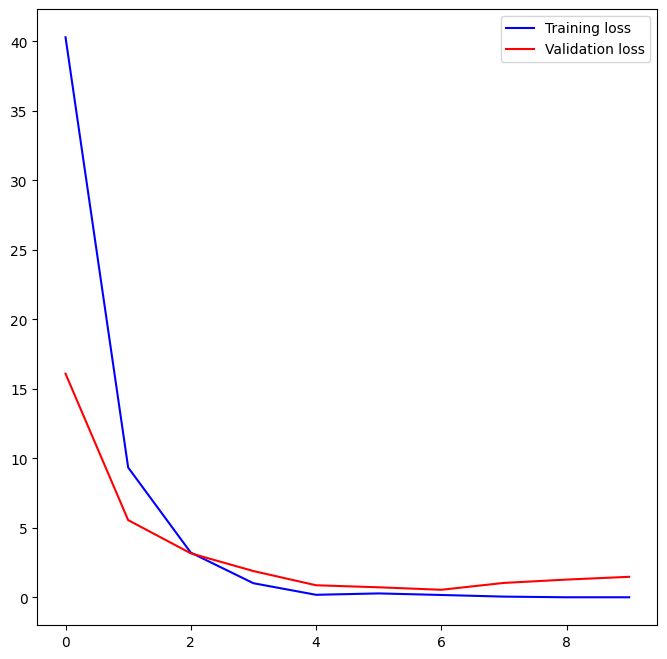

<Figure size 640x480 with 0 Axes>

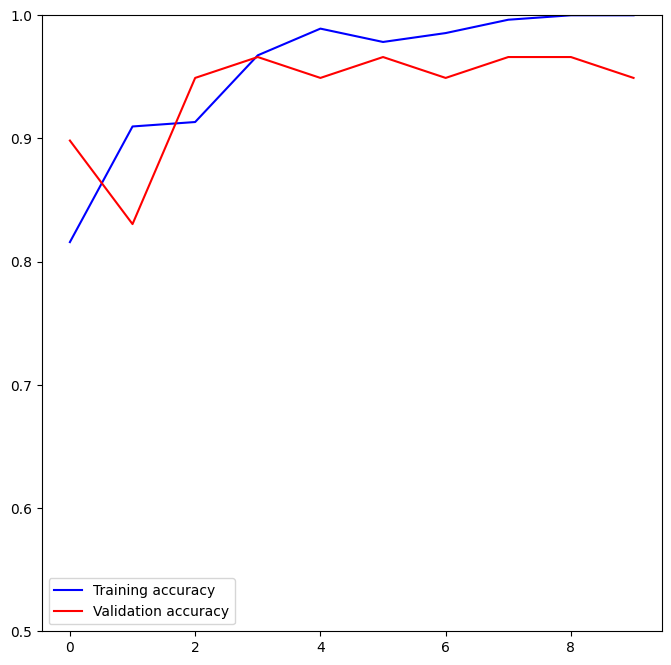

In [13]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

#### Testing on model till Last Epoch

1/1 [==============================] - 1s 1s/step


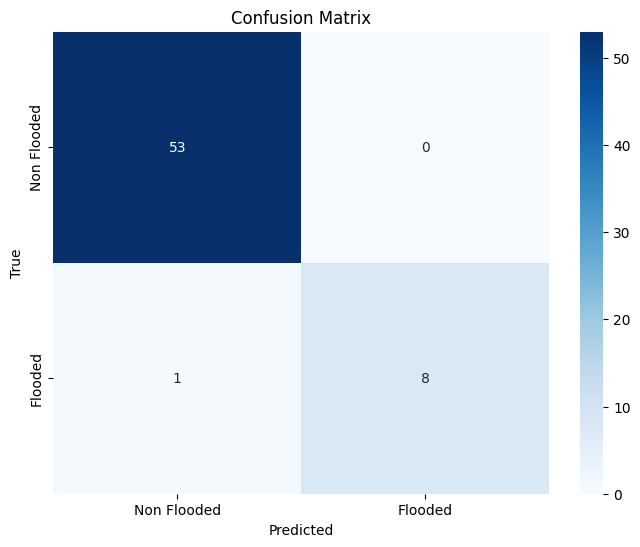

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       1.00      0.89      0.94         9

    accuracy                           0.98        62
   macro avg       0.99      0.94      0.97        62
weighted avg       0.98      0.98      0.98        62



In [14]:
predictions = model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

#### Testing on model which is last best saved

['floodnet_MobileNet-weights-improvement-04-0.97.hdf5']
Best model loaded ...
1/1 [==============================] - 3s 3s/step


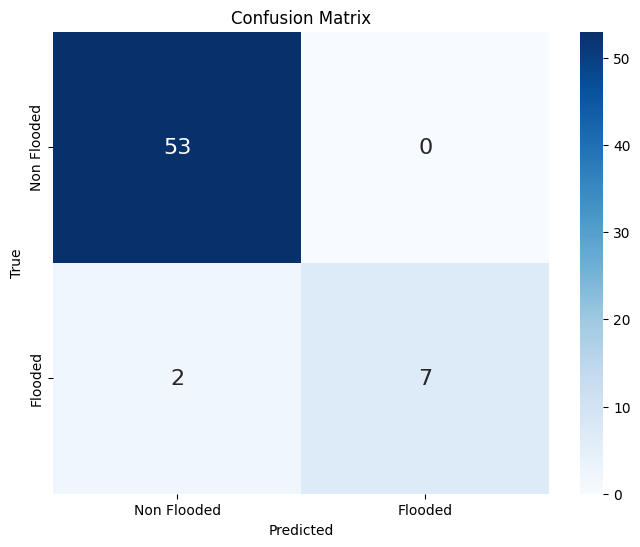

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        53
           1       1.00      0.78      0.88         9

    accuracy                           0.97        62
   macro avg       0.98      0.89      0.93        62
weighted avg       0.97      0.97      0.97        62



In [5]:
model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'

models = sorted(os.listdir(model_dir))

for file in models[:-1]:
    os.remove(f'{model_dir}\{file}')

print(os.listdir(model_dir))
best_model = load_model(f'{model_dir}\{models[-1]}')
print('Best model loaded ...')

predictions = best_model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'], annot_kws={'size':16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

## Other Dataset Testing

In [8]:
floodnet_testing = f'{data_saved_dir}\\floodnet_testing.pkl'
aider_testing = f'{data_saved_dir}\AIDER_testing.pkl'
floodAreaSeg_testing = f'{data_saved_dir}\FloodAreaSeg_testing.pkl'
download_testing = f'{data_saved_dir}\Downloaded_testing.pkl'

model  = best_model

## Floodnet Images

Testing images: (62, 256, 256, 3)
Class Balance: [0: 53, 1: 9]
2/2 [==============================] - 0s 229ms/step


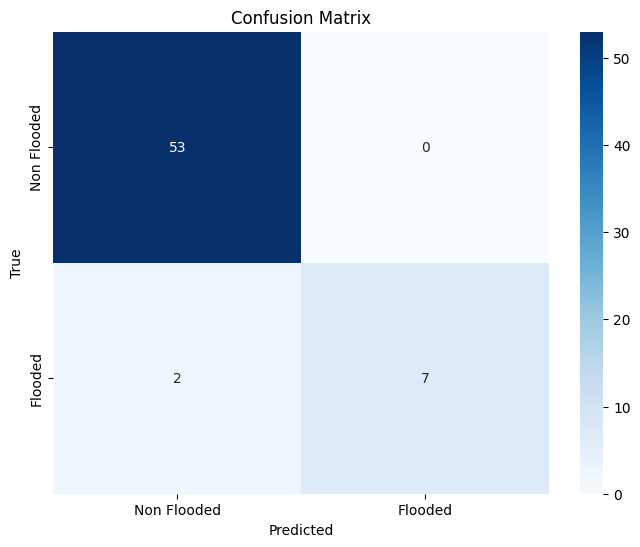

Accuracy: 0.967741935483871
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        53
           1       1.00      0.78      0.88         9

    accuracy                           0.97        62
   macro avg       0.98      0.89      0.93        62
weighted avg       0.97      0.97      0.97        62



In [10]:
from sklearn.metrics import accuracy_score

def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data


test_images, test_labels = load_pickle(floodnet_testing)
print(f'Testing images: {test_images.shape}')

class0 = len([i for i in test_labels if i == 0])
print(f'Class Balance: [0: {class0}, 1: {len(test_labels)-class0}]')

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy_score(test_labels, predicted_labels)}')
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

## AIDER Images

Testing images: (739, 256, 256, 3)
Class Balance: [0: 659, 1: 80]
24/24 [==============================] - 1s 43ms/step


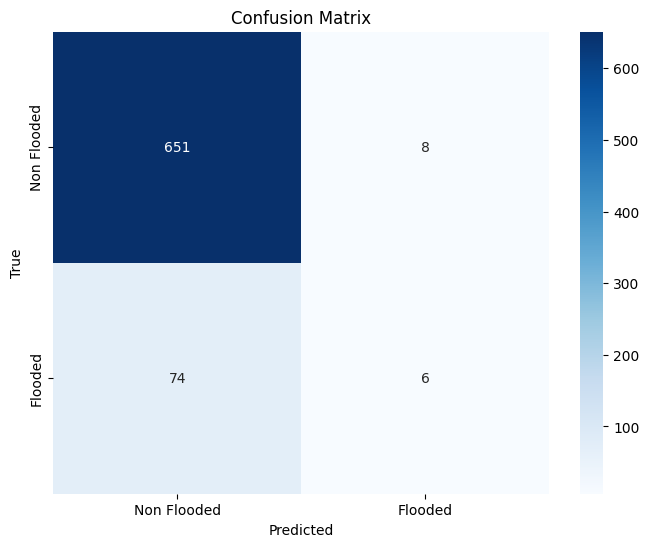

Accuracy: 0.8890392422192152
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       659
           1       0.43      0.07      0.13        80

    accuracy                           0.89       739
   macro avg       0.66      0.53      0.53       739
weighted avg       0.85      0.89      0.85       739



In [11]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data


test_images, test_labels = load_pickle(aider_testing)
print(f'Testing images: {test_images.shape}')

class0 = len([i for i in test_labels if i == 0])
print(f'Class Balance: [0: {class0}, 1: {len(test_labels)-class0}]')

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy_score(test_labels, predicted_labels)}')
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

## Flood Area Segmentation Images

Testing images: (44, 256, 256, 3)
Class Balance: [0: 0, 1: 44]
2/2 [==============================] - 0s 419ms/step


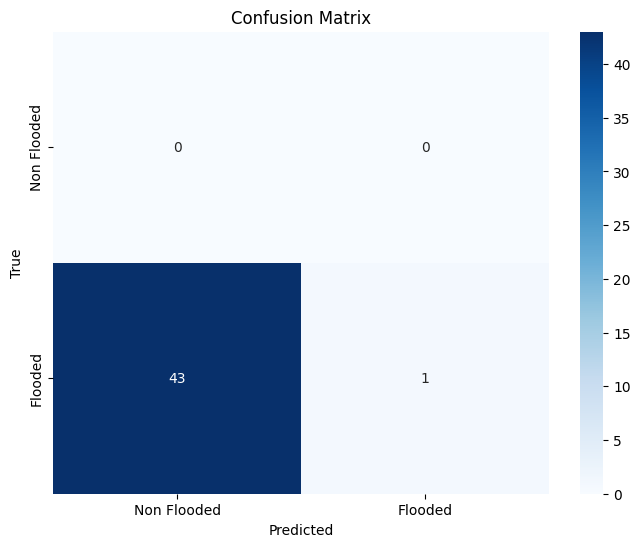

Accuracy: 0.022727272727272728
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.02      0.04        44

    accuracy                           0.02        44
   macro avg       0.50      0.01      0.02        44
weighted avg       1.00      0.02      0.04        44



c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [12]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data


test_images, test_labels = load_pickle(floodAreaSeg_testing)
print(f'Testing images: {test_images.shape}')

class0 = len([i for i in test_labels if i == 0])
print(f'Class Balance: [0: {class0}, 1: {len(test_labels)-class0}]')

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy_score(test_labels, predicted_labels)}')
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

## Google Images

Testing images: (145, 256, 256, 3)
Class Balance: [0: 52, 1: 93]
5/5 [==============================] - 1s 164ms/step


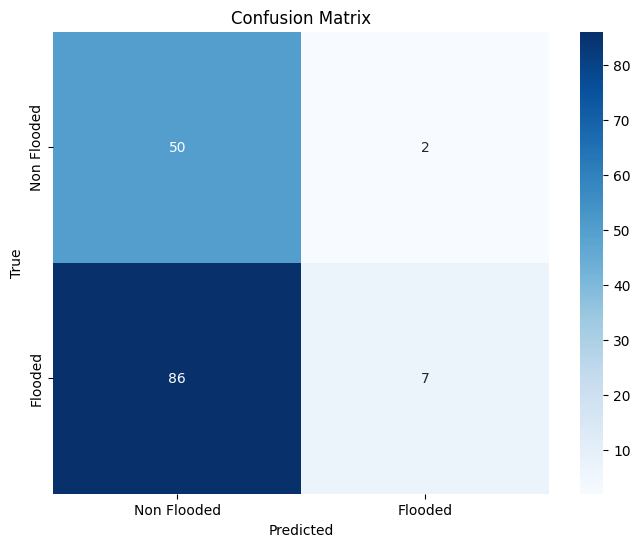

Accuracy: 0.3931034482758621
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.96      0.53        52
           1       0.78      0.08      0.14        93

    accuracy                           0.39       145
   macro avg       0.57      0.52      0.33       145
weighted avg       0.63      0.39      0.28       145



In [13]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data


test_images, test_labels = load_pickle(download_testing)
print(f'Testing images: {test_images.shape}')

class0 = len([i for i in test_labels if i == 0])
print(f'Class Balance: [0: {class0}, 1: {len(test_labels)-class0}]')

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy_score(test_labels, predicted_labels)}')
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))